In [1]:
setwd("~/work/fibroblast_timecourse")

load("data/shiny_rnaseq.rda")

source("R/002_helper_functions.R")

## Load packages

In [2]:
pacman::p_load(
  stringr,
  limma,
  RColorBrewer,
  dplyr,
  data.table,
  fractional,
  ggplot2,
  ggrepel,
  ggrastr,
  seriation,
  magrittr,
  patchwork,
  scales,
  forcats
)

In [3]:
theme_set(theme_classic(base_size = 18) %+replace% theme(strip.background = element_blank(),
  # axis.line.y = element_line(colour = "black", size = 0.2),
  # axis.line.x = element_line(colour = "black", size = 0.2),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank(),
  plot.title   = element_text(size = 18, vjust = 2, hjust = 0.5)
))

In [4]:
sirnas <- c("CUX1", "ELF3", "LIFR", "STAT3", "STAT4")

meta_colors <- list()
meta_colors$sirna <- c(
  "Ctrl"  = "black",
  "CUX1"  = '#1B9E77',
  "STAT3" = '#D95F02',
  "STAT4" = '#7570B3',
  "ELF3"  = '#E7298A',
  "LIFR"  = '#66A61E'
)

meta_colors$Stimulation <- c(
  "None" = "grey50",
  "TNF (1)" = "#FEB24C",
  "TNF (1) + IL17 (1)" = "#E31A1C",
  "TNF (1) + IL17 (10)" = "#800026"
)

meta_colors$dosefactor <- c(
  "0" = meta_colors$Stimulation[["TNF (1)"]],
  "1" = meta_colors$Stimulation[["TNF (1) + IL17 (1)"]],
  "10" = meta_colors$Stimulation[["TNF (1) + IL17 (10)"]]
)

## Load data

In [5]:
fit1_top <- data.table::fread("gzip -cd analysis/limma/002_dose_limma_timefactor_dosefactor.tsv.gz")

In [6]:
coef_to_stim <- c("d1" = "TNF (1) + IL17 (1)", "d10" = "TNF (1) + IL17 (10)")
for (x in c("Intercept", "t10", "t12", "t18", "t2", "t24", "t4", "t6", "t8")) {
  coef_to_stim[x] <- "TNF (1)"
}
print(coef_to_stim)

fit1_top$Stimulation <- coef_to_stim[fit1_top$Coef]
head(fit1_top)

                   d1                   d10             Intercept 
 "TNF (1) + IL17 (1)" "TNF (1) + IL17 (10)"             "TNF (1)" 
                  t10                   t12                   t18 
            "TNF (1)"             "TNF (1)"             "TNF (1)" 
                   t2                   t24                    t4 
            "TNF (1)"             "TNF (1)"             "TNF (1)" 
                   t6                    t8 
            "TNF (1)"             "TNF (1)" 


ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,signif,Stimulation
GAPDH,12.2361,12.1392,12.3330,11.9755,249.3115,1.073e-216,2.133e-212,449.8856,ENSG00000111640,Intercept,TRUE,TNF (1)
TPT1,12.2502,12.1431,12.3573,12.1497,225.8334,1.524e-209,1.515e-205,439.2062,ENSG00000133112,Intercept,TRUE,TNF (1)
UBB,10.3344,10.2414,10.4273,10.4976,219.5213,1.707e-207,1.131e-203,436.0108,ENSG00000170315,Intercept,TRUE,TNF (1)
SRP14,9.1075,9.0214,9.1936,9.0615,208.7697,7.266e-204,3.611e-200,430.2092,ENSG00000140319,Intercept,TRUE,TNF (1)
COX4I1,9.6292,9.5299,9.7285,9.6275,191.4095,1.355e-197,5.386e-194,419.7734,ENSG00000131143,Intercept,TRUE,TNF (1)
PPIB,9.9307,9.8237,10.0376,9.8865,183.3484,1.729e-194,5.729e-191,414.4209,ENSG00000166794,Intercept,TRUE,TNF (1)


In [7]:
cats <- readRDS("analysis/limma/cats.rds")

print(sapply(cats, length))

   C1    C2    C3    C4    C5  None 
   26    25   370    13   202 19243 


In [15]:
fit1_top$category <- 0
fit1_top$category[fit1_top$ensembl_id %in% cats$C1] <- 1
fit1_top$category[fit1_top$ensembl_id %in% cats$C2] <- 2
fit1_top$category[fit1_top$ensembl_id %in% cats$C3] <- 3
fit1_top$category[fit1_top$ensembl_id %in% cats$C4] <- 4
fit1_top$category[fit1_top$ensembl_id %in% cats$C5] <- 5

table(fit1_top$category)


     0      1      2      3      4      5 
211673    286    275   4070    143   2222 

In [18]:
dat <- reshape2::melt(
  data = dplyr::select(fit1_top, logFC, signif, ID, ensembl_id, category, Coef),
  id.vars = c("signif", "ID", "Coef", "ensembl_id", "category")
) %>%
# filter(signif) %>%
data.table::dcast(formula = ID + ensembl_id + category ~ Coef, fun.aggregate = mean, value.var = "value") %>%
mutate(signif = abs(d10) > log2(2) | abs(t6) > log2(2))

#colnames(dat) <- c("Gene", "DoseFactor10", "TimeFactor10", "signif")

subset(dat, ID %in% c("ELF3", "CSF3", "POU2F2", "CXCL1", "CXCL8", "MMP1", "ICAM1"))

,ID,ensembl_id,category,Intercept,d1,d10,t10,t12,t18,t2,t24,t4,t6,t8,signif
5547,CSF3,ENSG00000108342,1,3.1720e-15,1.9202,3.3297,0.2947,0.3079,0.80170,-1.0283,1.2396,-0.4698,-0.1939,-0.0280,TRUE
5668,CXCL1,ENSG00000163739,2,1.5713e+00,3.6019,4.6875,6.3525,6.3977,6.34660,6.5649,6.3551,6.2818,6.2824,6.3267,TRUE
5680,CXCL8,ENSG00000169429,2,6.3180e-01,1.3469,1.8039,10.9978,11.1171,10.89080,8.5626,10.7012,9.8261,10.4191,10.8254,TRUE
6645,ELF3,ENSG00000163435,1,8.0760e-01,1.4482,2.4315,0.1919,0.2745,0.83900,-0.5674,0.9596,-0.0422,-0.0838,-0.0332,TRUE
9035,ICAM1,ENSG00000090339,3,3.3475e+00,-0.3027,-0.6195,6.1024,5.7718,4.87550,5.9629,4.5246,6.7512,6.6240,6.3932,TRUE
10887,MMP1,ENSG00000196611,3,4.0519e+00,0.2181,0.2765,6.4072,6.4222,6.90390,2.6748,7.3451,4.4194,5.4986,6.0622,TRUE
13290,POU2F2,ENSG00000028277,1,1.0900e+00,1.1779,1.7770,0.4057,0.7707,0.00118,-0.2927,0.3519,0.1084,0.6022,0.5003,TRUE


In [33]:
plot_coef <- function(fit1_top, coef = "t6", these_genes = c("RASD1", "CXCL1"), title = "TNF") {
  
#   fill_values <- meta_colors$Stimulation[["TNF (1)"]]
#   if (coef %in% c("d1", "d10")) {
#     fill_values <- meta_colors$Stimulation[["TNF (1)"]]
  
  d <- fit1_top %>%
#   filter(ensembl_id %in% these_genes | ID %in% these_genes) %>%
  filter(ID %in% these_genes) %>%
  mutate(ID = factor(as.character(ID), these_genes)) %>%
  filter(Coef %in% c(coef)) %>%
  mutate(signif = adj.P.Val < 0.05)
  
  ggplot(d) +
  coord_flip() +
  geom_hline(yintercept = 0, size = 0.2) +
  geom_hline(yintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
  geom_errorbar(
    mapping = aes(x = ID, ymin = CI.L, ymax = CI.R, alpha = signif, group = Coef),
    width = 0,
    size = 0.5,
    position = position_dodge(width = 0.5)
  ) +
  annotate(
    geom = "rect",
    ymin = -Inf, ymax = Inf,
    xmin = seq(0.5, length(these_genes) - 0.5, by = 2),
    xmax = seq(0.5, length(these_genes) - 0.5, by = 2) + 1,
    fill = "grey80",
    alpha = 0.25
  ) +
  geom_point(
    mapping = aes(x = ID, y = logFC, alpha = signif, group = Coef, fill = Stimulation),
    position = position_dodge(width = 0.5),
    shape = 21, size = 3.5, stroke = 0.5
  ) +
  scale_fill_manual(values = meta_colors$Stimulation) +
  scale_alpha_manual(
    guide = FALSE,
    name = NULL,
    values = c(
      "TRUE" = 1,
      "FALSE" = 0.33
    )
  ) +
  guides(fill = guide_legend(override.aes = list(size = 3.5))) +
  scale_x_discrete(expand = c(0, 0.5)) +
  scale_y_continuous(
    labels = function(x) fractional(2^x),
    breaks = scales::pretty_breaks(3)
  ) +
  labs(title = title, y = NULL, x = NULL) +
  theme(
    legend.title = element_text(size = 18),
    plot.title = element_text(size = 20, hjust = 0.5),
#     legend.position = "right",
    legend.position = "none",
    panel.grid.major = element_blank(),
    # panel.grid.major = element_line(size = 0.2, color = "grey80"),
    panel.spacing = unit(1, "lines"),
    axis.text.y = element_text(face = "italic", size = 20),
    axis.ticks.y = element_blank(),
    axis.text.x = element_text(size = 20),
    strip.text = element_text(face = "italic")
  )
}

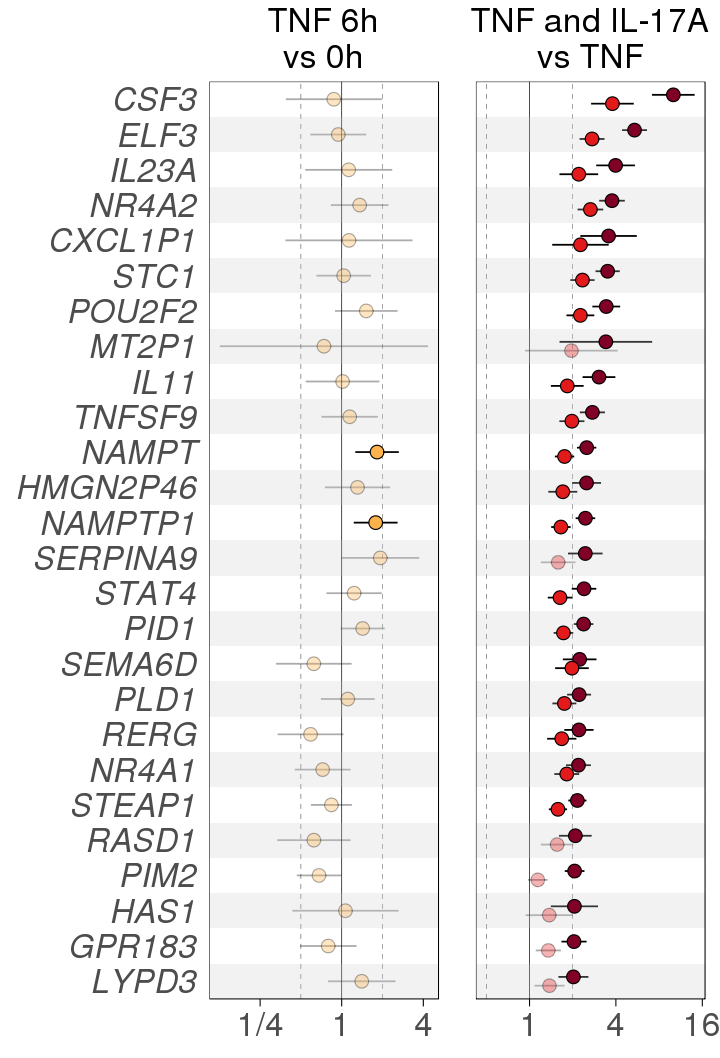

In [53]:
# these_genes <- c(
#   "CSF3", "IL11", "NR4A2", "POU2F2", "ELF3",
#   "CXCL1", "CXCL2", "CXCL3", "CXCL5", "CXCL6", "CXCL8", "CXCL11",
#   "TNFAIP6", "TNFAIP2", "MMP1", "BDKRB1",
#   "IRF1", "IRF9", "IFI30",
#   "STMN1", "CDKN2C", "CDC20"
# )

these_genes <- gene_symbols[(
  dat %>%
  filter(ensembl_id %in% cats$C1) %>%
  arrange(d10)
)$ensembl_id]

options(repr.plot.width = 6, repr.plot.height = 0.5 + length(these_genes) * 0.32)

p1 <- plot_coef(fit1_top, coef = "t6", title = "TNF 6h\nvs 0h", these_genes = these_genes)

p2 <- plot_coef(fit1_top, coef = c("d1", "d10"), title = "TNF and IL-17A\nvs TNF", these_genes = these_genes) +
theme(axis.text.y = element_blank())

show_plot(name = "category-c1", p1 + p2)

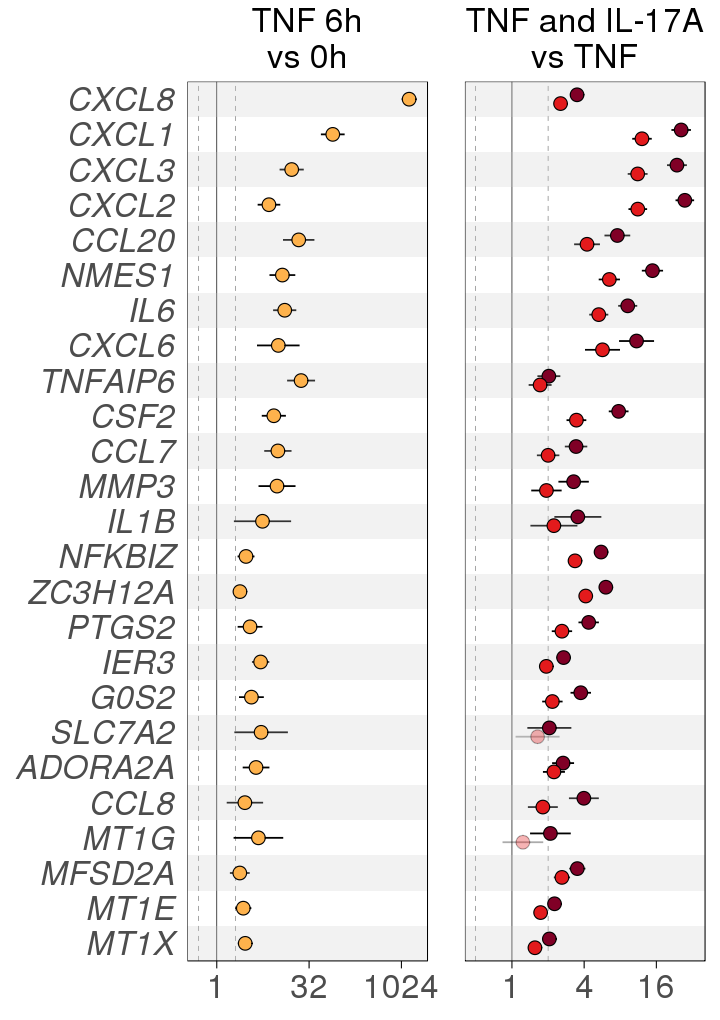

In [54]:
these_genes <- gene_symbols[(
  dat %>%
  filter(ensembl_id %in% cats$C2) %>%
  arrange(d10 ^ 2 + t6 ^ 2)
)$ensembl_id]

options(repr.plot.width = 6, repr.plot.height = 0.5 + length(these_genes) * 0.32)

p1 <- plot_coef(fit1_top, coef = "t6", title = "TNF 6h\nvs 0h", these_genes = these_genes)

p2 <- plot_coef(fit1_top, coef = c("d1", "d10"), title = "TNF and IL-17A\nvs TNF", these_genes = these_genes) +
theme(axis.text.y = element_blank())

show_plot(name = "category-c2", p1 + p2)

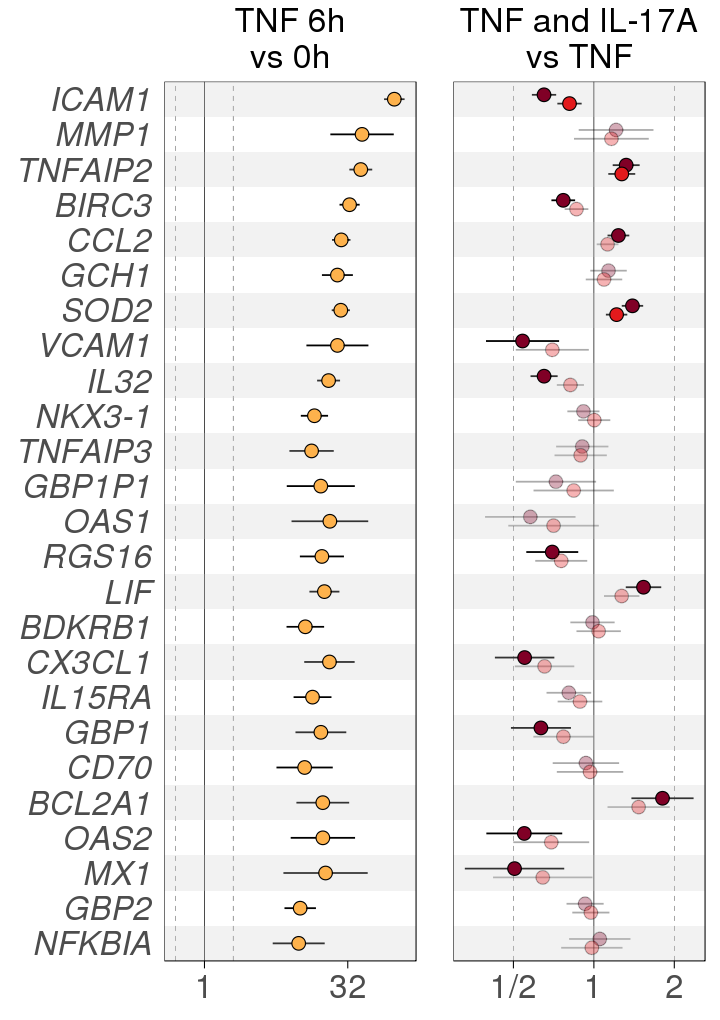

In [55]:
these_genes <- gene_symbols[(
  dat %>%
  filter(ensembl_id %in% cats$C3) %>%
  arrange(t6 - abs(d10)) %>%
  tail(25)
)$ensembl_id]

options(repr.plot.width = 6, repr.plot.height = 0.5 + length(these_genes) * 0.32)

p1 <- plot_coef(fit1_top, coef = "t6", title = "TNF 6h\nvs 0h", these_genes = these_genes)

p2 <- plot_coef(fit1_top, coef = c("d1", "d10"), title = "TNF and IL-17A\nvs TNF", these_genes = these_genes) +
theme(axis.text.y = element_blank())

show_plot(name = "category-c3", p1 + p2)

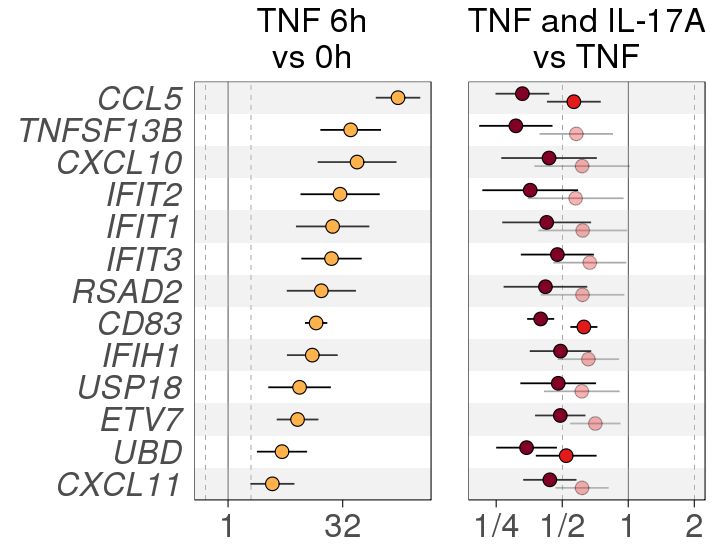

In [56]:
these_genes <- gene_symbols[(
  dat %>%
  filter(ensembl_id %in% cats$C4) %>%
  arrange(t6 - d10) %>%
  tail(25)
)$ensembl_id]

options(repr.plot.width = 6, repr.plot.height = 0.5 + length(these_genes) * 0.32)

p1 <- plot_coef(fit1_top, coef = "t6", title = "TNF 6h\nvs 0h", these_genes = these_genes)

p2 <- plot_coef(fit1_top, coef = c("d1", "d10"), title = "TNF and IL-17A\nvs TNF", these_genes = these_genes) +
theme(axis.text.y = element_blank())

show_plot(name = "category-c4", p1 + p2)

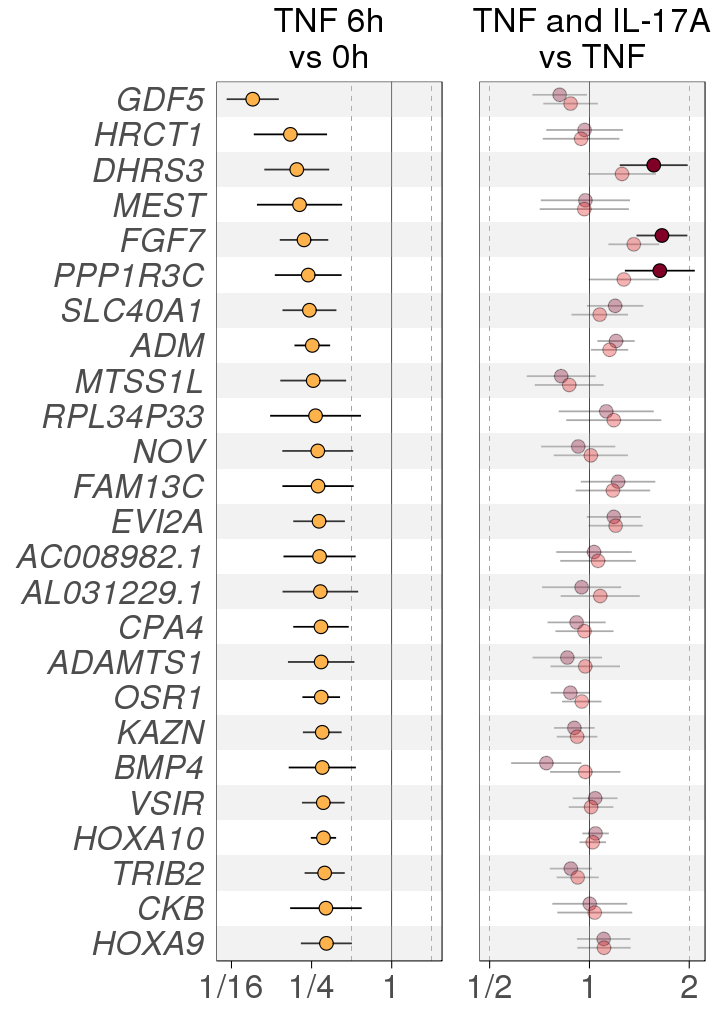

In [57]:
these_genes <- gene_symbols[(
  dat %>%
  filter(ensembl_id %in% cats$C5) %>%
  arrange(-t6) %>%
  tail(25)
)$ensembl_id]

options(repr.plot.width = 6, repr.plot.height = 0.5 + length(these_genes) * 0.32)

p1 <- plot_coef(fit1_top, coef = "t6", title = "TNF 6h\nvs 0h", these_genes = these_genes)

p2 <- plot_coef(fit1_top, coef = c("d1", "d10"), title = "TNF and IL-17A\nvs TNF", these_genes = these_genes) +
theme(axis.text.y = element_blank())

show_plot(name = "category-c5", p1 + p2)